# PROJECT STEPS



<li> Data Collection and Problem Statement</li>
<li> Exploratory Data Analysis with Pandas and NumPy</li>
<li> Data Preparation using Sklearn</li>
<li> Selecting and Training a few Machine Learning Models
<li> Cross-Validation and Hyperparameter Tuning using Sklearn</li>
<li> Deploying the Final Trained Model</li>

# Introduction

- In the following midterm project , We will use the [Hotel booking demand data set](https://www.kaggle.com/jessemostipak/hotel-booking-demand) from Kaggle, to predict whenever a customer's booking will be cancelled or not
 .

This data set contains a single file which compares various booking information between two hotels: a resort hotel(H1), and a city hotel(H2)  , comprehending bookings due to arrive between July of 2015 and the 31st of August 2017, including bookings that effectively arrived and bookings that were canceled. [Article](https://www.sciencedirect.com/science/article/pii/S2352340918315191)



## Task: Predict the possibility of a booking

In [41]:
# importing necessary modules


import pygal
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import plotly.express as px
import gc
import os
import kaleido
plt.style.use('ggplot')

import subprocess

from subprocess import check_output
import gc

%matplotlib inline


## Downloading  the data set

In [42]:
!kaggle datasets download -d jessemostipak/hotel-booking-demand

 80%|██████████████████████████████▍       | 1.00M/1.25M [00:00<00:00, 2.72MB/s]
100%|██████████████████████████████████████| 1.25M/1.25M [00:00<00:00, 3.18MB/s]


In [43]:
# Unziping the data 
import zipfile
with zipfile.ZipFile('hotel-booking-demand.zip', 'r') as zip_ref:
    zip_ref.extractall('input')\

os.remove('hotel-booking-demand.zip')

## Reading the data set

In [44]:
df = pd.read_csv('input/hotel_bookings.csv')

In [45]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [46]:
# checking amount of rows and columns

df.shape

(119390, 32)

## Exploratory Data Analysis with Pandas and NumPy


In [47]:
# checking data types

df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [48]:
df.nunique() # checking unique values

hotel                                2
is_canceled                          2
lead_time                          479
arrival_date_year                    3
arrival_date_month                  12
arrival_date_week_number            53
arrival_date_day_of_month           31
stays_in_weekend_nights             17
stays_in_week_nights                35
adults                              14
children                             5
babies                               5
meal                                 5
country                            177
market_segment                       8
distribution_channel                 5
is_repeated_guest                    2
previous_cancellations              15
previous_bookings_not_canceled      73
reserved_room_type                  10
assigned_room_type                  12
booking_changes                     21
deposit_type                         3
agent                              333
company                            352
days_in_waiting_list     

# Cleaning the Data

In [49]:
df.isnull().sum() # Null values

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

We can see that the features that present the more amount of NULL values are:

- Company:ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons


- Agent:ID of the travel agency that made the booking


- Country:Country of origin. Categories are represented in the ISO 3155–3:2013 format



From the article , the `NULL` values present in the categorical variables of `company` and `agent` should not be considered as missing , rather as "not applicable" meaning that the customer did not come with a traveling agent or company. So we leave them untouched 

Answering a few questions with EDA:

- Where do the guests come from? (Country of H1 and H2)
- How much guests come in each month ?
- How likely is for a repeated guest to cancel a booking
- Main customers type

1) Mapping Guests

In [50]:
from collections import Counter

count = Counter(df.country)

In [51]:
count

Counter({'PRT': 48590,
         'GBR': 12129,
         'USA': 2097,
         'ESP': 8568,
         'IRL': 3375,
         'FRA': 10415,
         nan: 488,
         'ROU': 500,
         'NOR': 607,
         'OMN': 18,
         'ARG': 214,
         'POL': 919,
         'DEU': 7287,
         'BEL': 2342,
         'CHE': 1730,
         'CN': 1279,
         'GRC': 128,
         'ITA': 3766,
         'NLD': 2104,
         'DNK': 435,
         'RUS': 632,
         'SWE': 1024,
         'AUS': 426,
         'EST': 83,
         'CZE': 171,
         'BRA': 2224,
         'FIN': 447,
         'MOZ': 67,
         'BWA': 1,
         'LUX': 287,
         'SVN': 57,
         'ALB': 12,
         'IND': 152,
         'CHN': 999,
         'MEX': 85,
         'MAR': 259,
         'UKR': 68,
         'SMR': 1,
         'LVA': 55,
         'PRI': 12,
         'SRB': 101,
         'CHL': 65,
         'AUT': 1263,
         'BLR': 26,
         'LTU': 81,
         'TUR': 248,
         'ZAF': 80,
         'AGO':

In [52]:
df_resort = df.loc[df.hotel=='Resort Hotel'] # pick members from H1

In [62]:
import matplotlib.image as img

def show_country_map(country):
    c = Counter(country)
    country = pd.DataFrame.from_records(list(dict(c).items()), columns=['country','count'])
    total_guests = country["count"].sum()
    country["Guests in %"] = round(country["count"] / total_guests * 100, 2)
    guest_map = px.choropleth(country,
                    locations=country.country,
                    color=country["Guests in %"], 
                    hover_name=country.country, 
                    color_continuous_scale=px.colors.sequential.Inferno,
                    title="Home country of Guests ")
    guest_map.write_image("map.png", width=1980, height=1080)
    im = img.imread('map.png')
    # show image
    fig = plt.gcf()
    fig.set_size_inches(20,20)
    plt.imshow(im)


In [63]:
def plot_pie(country):
    c = Counter(country)
    
    country = pd.DataFrame.from_records(list(dict(c).items()), columns=['country','count'])
    plt.pie(country["count"],labels=country["country"])

    plt.title("Home country of Guests")
    fig = plt.gcf()
    fig.set_size_inches(8,8)
    plt.show()

In [64]:
df.hotel.value_counts()

City Hotel      79330
Resort Hotel    40060
Name: hotel, dtype: int64

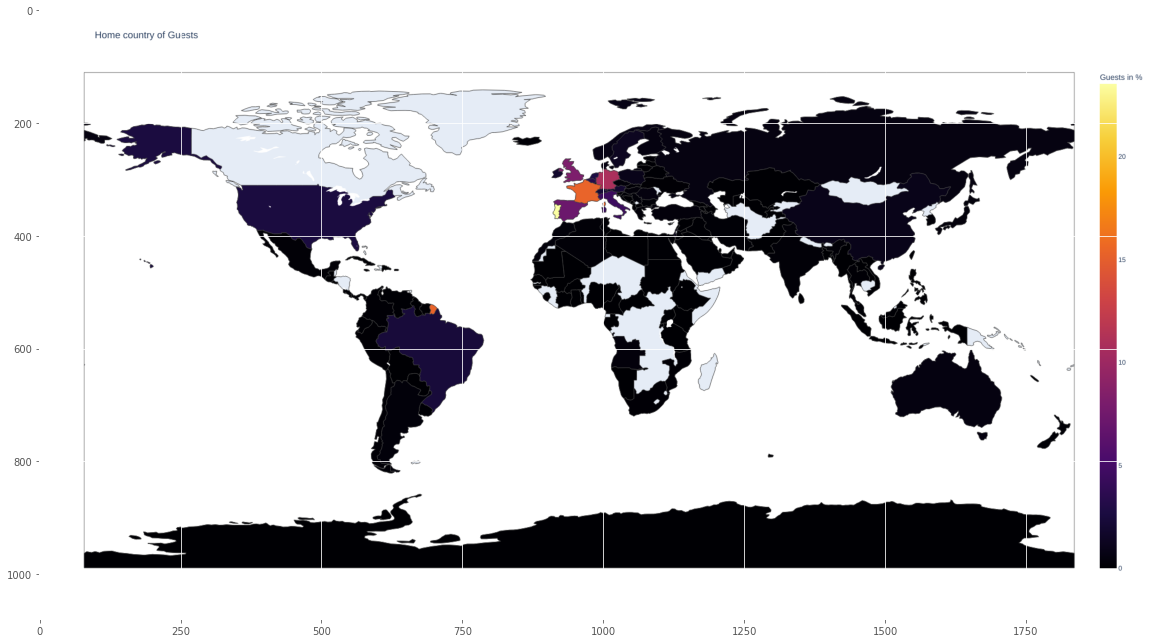

In [65]:
# For H1

df_city = df.loc[df.hotel == 'City Hotel']

show_country_map(df_city.loc[ df_city.is_canceled == 0 ].country)

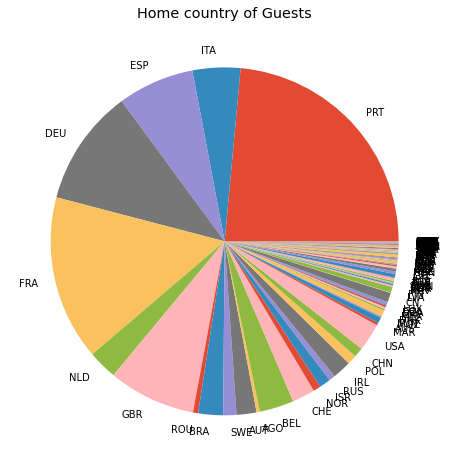

In [69]:
plot_pie(df_city.loc[ df_city.is_canceled == 0 ].country)

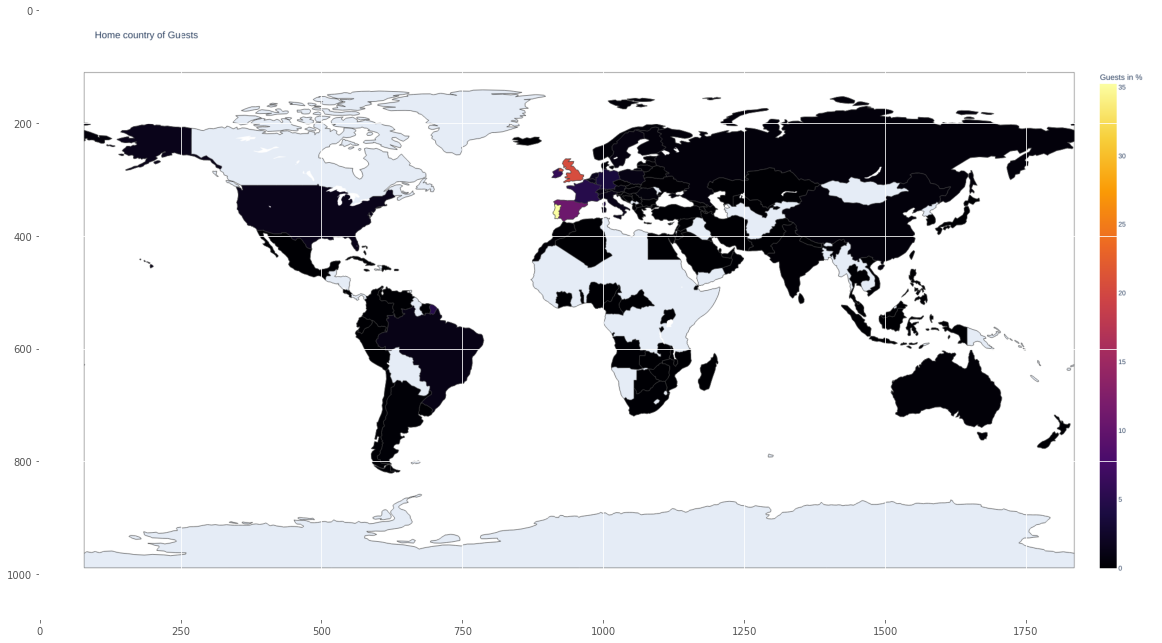

In [67]:
# For H2

df_resort = df.loc[df.hotel == 'Resort Hotel']

show_country_map(df_resort.loc[ df_resort.is_canceled == 0 ].country)

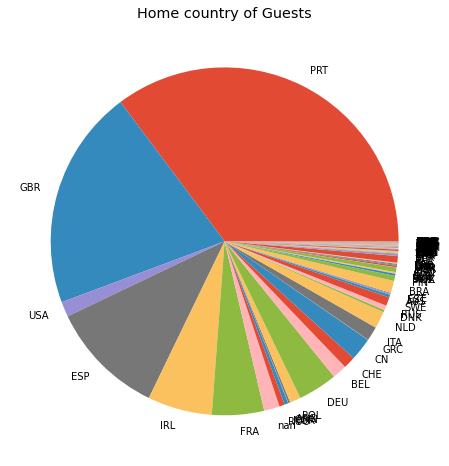

In [68]:
plot_pie(df_resort.loc[ df_resort.is_canceled == 0 ].country)

How much guests come each month ? 

<AxesSubplot:>

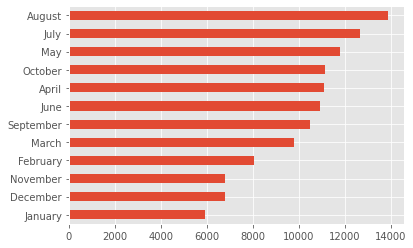

In [60]:
df.arrival_date_month.value_counts().sort_values().plot.barh()


<AxesSubplot:>

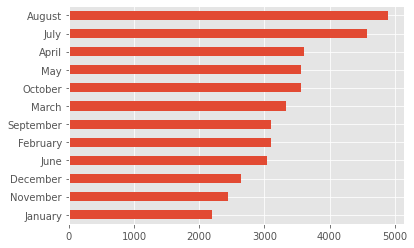

In [61]:
df_resort.arrival_date_month.value_counts().sort_values().plot.barh()
